## [시계열데이터처리] 비트코인 시세예측
##### 2017-2020년, 3년의 데이터를 가지고 4월 한달간 비트코인 변화 예측

#### 시계열 데이터란

#### 데이터 로드

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 3년치 데이터 로드
train_path = 'train.csv'
train = pd.read_csv(train_path, skiprows = [0], names=['time', 'price'] )

In [3]:
# 4월 데이터 로드 (04-25 기준)
test_path = 'test.csv'
test = pd.read_csv(test_path,skiprows = [0], names=['time', 'price'] )

In [4]:
print(train.shape)
print(test.shape)

(1091, 2)
(7, 2)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 2 columns):
time     1091 non-null object
price    1091 non-null float64
dtypes: float64(1), object(1)
memory usage: 17.2+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
time     7 non-null object
price    7 non-null float64
dtypes: float64(1), object(1)
memory usage: 240.0+ bytes


In [7]:
train.head()

,time,price
0,2017-04-26 0:00,1272.67
1,2017-04-27 0:00,1288.02
2,2017-04-28 0:00,1330.33
3,2017-04-29 0:00,1330.70
4,2017-04-30 0:00,1333.00


In [8]:
test.head()

,time,price
0,2020-04-19 0:00,7259.36
1,2020-04-20 0:00,7130.04
2,2020-04-21 0:00,6840.24
3,2020-04-22 0:00,6852.52
4,2020-04-23 0:00,7130.99


#### 가격 추이 시각화

In [9]:
# to_datetime 메소드를 통해 day 피처를 시계열 피처 처리
train['time'] = pd.to_datetime(train['time'])
# 프레임 인덱스 설정
train.index = train['time']
train.set_index('time', inplace=True)

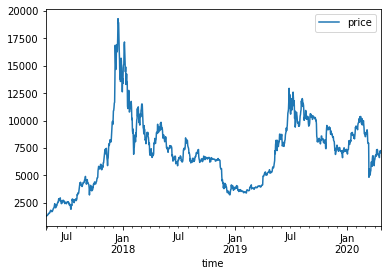

In [10]:
# 시각화
train.plot()
plt.show()

#### ARIMA 분석 방법

##### 1. AR모델로 자신의 과거를 정보로 사용하는 개념(현재의 상태는 이전의 상태를 참고해서 계산된다)
##### 2. MA모델로 이전 항에서의 오차를 이용하여 현재 항의 상태를 추론하겠다
##### 파이썬에서는 statsmodel 모듈로 arima분석을 수행할 수 있다. 

In [11]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

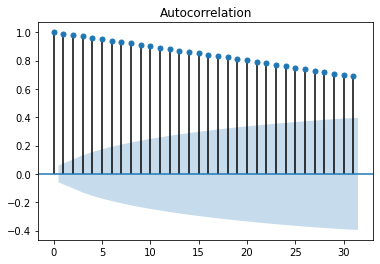

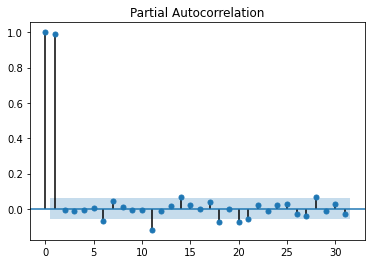

In [14]:
#ARIMA 의 order 파라미터 p,d,q의 최적 조합 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train)
plot_pacf(train)
plt.show()
# 자기상관은 항상 양 
# 급격 감소 q=1

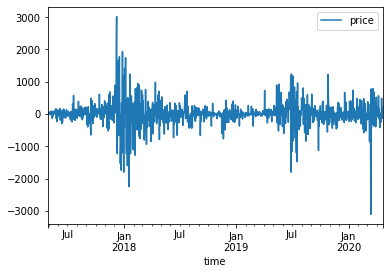

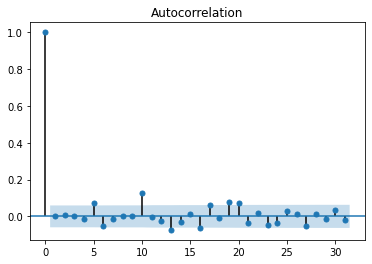

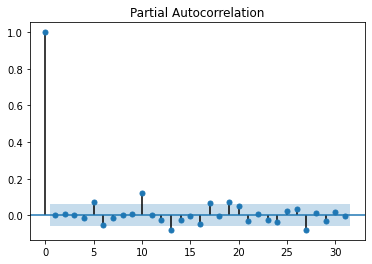

In [21]:
# 적절 차분 차수 d 계산 
tmp=train.diff(periods=1).iloc[1:] # 2차 차분
tmp.plot()
plot_acf(tmp)
plot_pacf(tmp)
plt.show()
# 시계열 정상상태. (p, d, q) = (0, 2, 1)

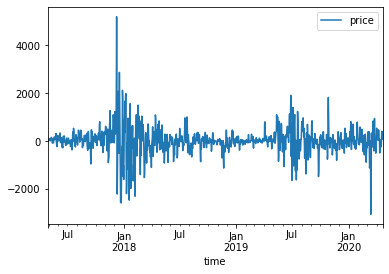

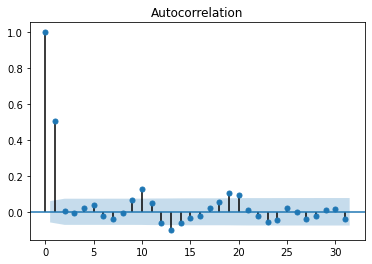

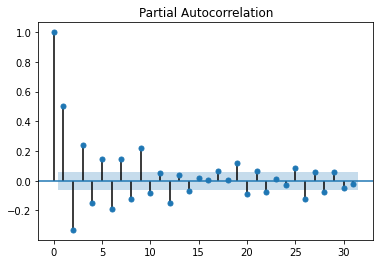

In [26]:
# 적절 차분 차수 d 계산 
tmp=train.diff(periods=2).iloc[2:] # 2차 차분
tmp.plot()
plot_acf(tmp)
plot_pacf(tmp)
plt.show()
# 시계열 정상상태. (p, d, q) = (0, 2, 1)

In [37]:
# AR=2, 차분=1, MA=2 파라미터로 ARIMA 모델을 학습 -> 파라미터 조정 필요하나 생략함 따라서 임의설정
model = ARIMA(train.price.values, order=(0,2,1))
model_fit = model.fit(trend='c', full_output=True, disp=True)

In [38]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 1089
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -8038.507
Method:                       css-mle   S.D. of innovations            387.378
Date:                Sat, 25 Apr 2020   AIC                          16083.015
Time:                        20:17:14   BIC                          16097.994
Sample:                             2   HQIC                         16088.684
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0285      0.037     -0.763      0.445      -0.102       0.045
ma.L1.D2.y    -1.0000      0.003   -356.421      0.000      -1.005      -0.995
                                    Roots           

In [23]:
# P 값이 t-test
# 0.05 수준에서 상수 부적절
# c->nc
model = ARIMA(train.price.values, order=(0,2,1))
model_fit = model.fit(trend='nc', full_output=True, disp=True)

In [24]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 1089
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -8038.799
Method:                       css-mle   S.D. of innovations            387.481
Date:                Sat, 25 Apr 2020   AIC                          16081.597
Time:                        18:15:21   BIC                          16091.583
Sample:                             2   HQIC                         16085.377
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.D2.y    -1.0000      0.004   -269.811      0.000      -1.007      -0.993
                                    Roots                                    
                  Real          Imaginary           M

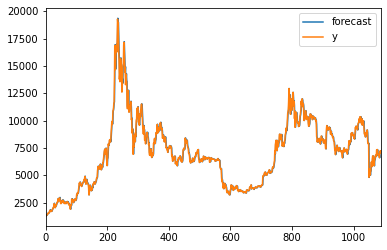

In [39]:
# 학습 데이터 예측 결과 -> 양호
fig = model_fit.plot_predict()

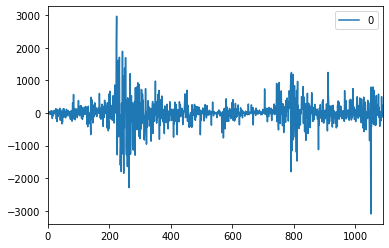

In [40]:
# 잔차의 변동 시각화
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
# 폭이 일정해야 좋음 -> 불규칙한 형태

#### 평가

In [41]:
# 4월 마지막주(7일) 시세 차트인 test 데이터 프레임 사용
pred_model = model_fit.forecast(steps=7)

In [42]:
# 7일간 예측 데이터
pred=pred_model[0].tolist()

In [44]:
# 실제 7일간 데이터
test=test.price.values

In [53]:
# 시각화
pred_lower = []
pred_upper = []
for lower_upper in pred_model[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_lower.append(lower)
    pred_upper.append(upper)

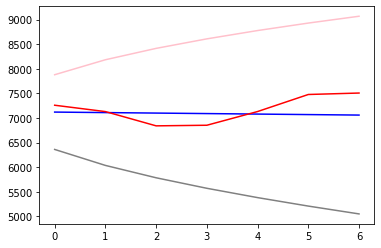

In [54]:
plt.plot(pred, color="blue") # 예측 가격
plt.plot(pred_lower, color = "gray") # 예측 최저가격
plt.plot(pred_upper, color = "pink") # 예측 최고가격
plt.plot(test, color = "red") # 실제가격

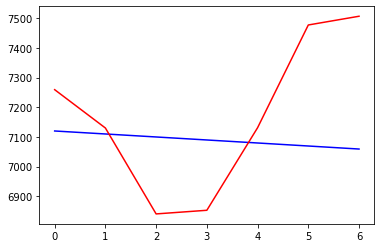

In [49]:
plt.plot(pred, color="blue") # 예측 가격
plt.plot(test, color = "red") # 실제가격

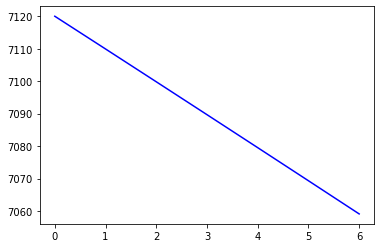

In [50]:
plt.plot(pred, color="blue") # 예측 가격
# 추이는 예측 성공

In [52]:
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(pred, test_y))
print(rmse)

270.8342603398055
